In [21]:
'''
this code shows the implementation of graphlet_sampling kernel ( which is expected to have the higher accuracy
than random features_based kernels, but much longer computational time)
'''
#!pip install grakel 
import time 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import networkx as nx
import grakel as gk 

from grakel.datasets import fetch_dataset
from grakel.kernels import ShortestPath
from grakel.kernels import GraphletSampling

import matplotlib.pyplot as plt

In [7]:
# DataSet Loading 

class dataset_loading:
    def __init__(self):
        pass 
    #mutag dataset
    def mutag(self,test_size=0.1):
        Gnx_train=[];
        Gnx_test=[];
        MUTAG = fetch_dataset("MUTAG", verbose=False,as_graphs=False)
        G, y = MUTAG.data, MUTAG.target
        G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1)
        for i in range(len(G_train)):
            g_current=nx.Graph(list(G_train[i][2]));
            g_current.add_nodes_from(G_train[i][1])
            Gnx_train.append(g_current)
        for i in range(len(G_test)):
            g_current=nx.Graph(list(G_test[i][2]));
            g_current.add_nodes_from(G_test[i][1])
            Gnx_test.append(g_current)
        return (Gnx_train,y_train), (Gnx_test,y_test)

    #SBM generator
    def generate_SBM(self,Graphs_num=300,nodes_per_graph=60,block_size=10,fraction=0.3,mult_factor=1.2,avg_deg=10,test_size=0.2):
        blocks_num=int(nodes_per_graph/block_size)
        sizes=[block_size]*blocks_num
        G,y=[],[]
        for i in range (Graphs_num):                  
            p_in=fraction  if i <Graphs_num/2 else fraction*mult_factor
            p_out=(avg_deg-(block_size-1)*p_in)/(nodes_per_graph-block_size)
            p=p_out*np.ones([blocks_num]*2)+(p_in-p_out)*np.eye(blocks_num)
            #print(p_in,p_out)
            G_cur=nx.stochastic_block_model(sizes, p)
            adj=[(i,j) for (i,j,_) in G_cur.edges(data=True)]
            node_labels=dict ((i,list(val.values())[0]) for (i,val) in G_cur.nodes(data=True) )
            
            G.append(gk.Graph(adj, node_labels=node_labels))
            y.append(-1 if i<Graphs_num/2 else 1)            
        G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=test_size)
        return (G_train,y_train),(G_test,y_test)
        

    # DD dataset
    def DD(self,test_size=0.1,train_size=800):
        DD = fetch_dataset("DD", verbose=True)
        G, y = DD.data, DD.target
        Gnx_train=[];
        Gnx_test=[];           # Taking just Train_size graphs of the data set as training set, 
                                       #this is due to the large computatational time
        G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=test_size)
        G_train,y_train=G_train[0:Train_size], y_train[0:Train_size]
        for i in range(len(G_train)):
            g_current=nx.Graph(list(G_train[i][0]));
            g_current.add_nodes_from(G_train[i][1])
            Gnx_train.append(g_current)
        for i in range(len(G_test)):
            g_current=nx.Graph(list(G_test[i][0]));
            g_current.add_nodes_from(G_test[i][1])
            Gnx_test.append(g_current)
        return (Gnx_train,y_train), (Gnx_test,y_test)


In [14]:
"""The graphlet sampling kernel :cite:`shervashidze2009efficient`."""
# Author: Ioannis Siglidis <y.siglidis@gmail.com>
# License: BSD 3 clause
import collections
import math
import warnings

import numpy as np

from scipy.interpolate import interp1d
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_is_fitted

from grakel.graph import Graph
from grakel.kernels import Kernel
from grakel.kernels._c_functions import ConSubg
from grakel.kernels._isomorphism import Graph as bGraph

# Python 2/3 cross-compatibility import
from six import iteritems
from six import itervalues
from builtins import range

class MyGraphletSampling(Kernel):
    r"""The graphlet sampling kernel.

    See :cite:`shervashidze2009efficient`.

    If either "delta", "epsilon", "a" or "n_samples" is given calculates
    the kernel value for the given (or derived) random picked n_samples, by
    randomly sampling from k from 3 to 5.
    Otherwise calculates the kernel value drawing all possible connected
    samples of size k.

    Parameters
    ----------
    random_state :  RandomState or int, default=None
        A random number generator instance or an int to initialize a RandomState as a seed.

    k : int, default=5
        The dimension of the given graphlets.

    sampling : None or dict
        Defines if random sampling of graphlets will be utilised.
        If not None the dictionary can either contain:

            - n_samples : int
                Sets the value of randomly drawn random samples,
                from sizes between 3..k. Overides the parameters a, epsilon,
                delta.
        or

            -  delta : float, default=0.05
               Confidence level (typically 0.05 or 0.1).
               For calculation of the number of samples achieving the certain
               bound. n_samples argument must not be provided and for
               initialising the default value either "epsilon" or
               "a" must be set.

            - epsilon : float, default=0.05
                Precision level (typically 0.05 or 0.1).
                For calculation of the number of samples achieving the certain
                bound. n_samples argument must not be provided and for
                initialising the default value either "delta" or
                "a" must be set.

            - a : int
                Number of isomorphism classes of graphlets.
                If -1 the number is the maximum possible, from a database
                1 until 9 or else predicted through interpolation.
                For calculation of the number of samples achieving the certain
                bound. n_samples argument must not be provided and for
                initializing the default value either "delta" or "epsilon" must
                be set.



    Attributes
    ----------
    X : dict
        A dictionary of pairs between each input graph and a bins where the
        sampled graphlets have fallen.

    sample_graphlets_ : function
        A function taking as input a binary adjacency matrix, parametrised
        to work for the certain samples, k and deterministic/propabilistic
        mode.

    random_state_ : RandomState
        A RandomState object handling all randomness of the class.

    _graph_bins : dict
        A dictionary of graph bins holding pynauty objects

    _nx : int
        Holds the number of sampled X graphs.

    _ny : int
        Holds the number of sampled Y graphs.

    _X_diag : np.array, shape=(_nx, 1)
        Holds the diagonal of X kernel matrix in a numpy array, if calculated
        (`fit_transform`).

    _phi_X : np.array, shape=(_nx, len(_graph_bins))
        Holds the features of X in a numpy array, if calculated.
        (`fit_transform`).

    """

    _graph_format = "adjacency"

    def __init__(self,
                 n_jobs=None,
                 normalize=False, verbose=False,
                 random_state=None,
                 k=5,
                 sampling=None):
        """Initialise a subtree_wl kernel."""
        super(MyGraphletSampling, self).__init__(n_jobs=n_jobs,
                                               normalize=normalize,
                                               verbose=verbose)

        self.random_state = random_state
        self.k = k
        self.sampling = sampling
        self._initialized.update({"random_state": False, "k": False, "sampling": False})


    def initialize(self):
        """Initialize all transformer arguments, needing initialization."""
        self._graph_bins = dict()
        if not self._initialized["n_jobs"]:
            if self.n_jobs is not None:
                warnings.warn('no implemented parallelization for GraphletSampling')
            self._initialized["n_jobs"] = True

        if not self._initialized["random_state"]:
            self.random_state_ = check_random_state(self.random_state)
            self._initialized["random_state"] = True

        if not self._initialized["k"]:
            if type(self.k) is not int:
                raise TypeError('k must be an int')

            if self.k > 10:
                warnings.warn('graphlets are too big - '
                              'computation may be slow')
            elif self.k < 3:
                raise TypeError('k must be bigger than 3')

            self._initialized["k"] = True

        if not self._initialized["sampling"]:
            sampling = self.sampling
            k = self.k
            if sampling is None:
                n_samples = None

                def sample_graphlets(A, k, *args):
                    return sample_graphlets_all_connected(A, k)
            elif type(sampling) is dict:
                if "n_samples" in sampling:
                    # Get the number of samples
                    n_samples = sampling["n_samples"]

                    # Display a warning if arguments ignored
                    args = [arg for arg in ["delta", "epsilon", "a"]
                            if arg in sampling]
                    if len(args):
                        warnings.warn('Number of samples defined as input, ' +
                                      'ignoring arguments:', ', '.join(args))

                    # Initialise the sample graphlets function
                    sample_graphlets = sample_graphlets_probabilistic

                elif ("delta" in sampling or "epsilon" in sampling
                        or "a" in sampling):
                    # Otherwise if delta exists
                    delta = sampling.get("delta", 0.05)
                    # or epsilon
                    epsilon = sampling.get("epsilon", 0.05)
                    # or a
                    a = sampling.get("a", -1)

                    # check the fit constraints
                    if delta > 1 or delta < 0:
                        raise TypeError('delta must be in the range (0,1)')

                    if epsilon > 1 or epsilon < 0:
                        raise TypeError('epsilon must be in the range (0,1)')

                    if type(a) is not int:
                        raise TypeError('a must be an integer')
                    elif a == 0:
                        raise TypeError('a cannot be zero')
                    elif a < -1:
                        raise TypeError('negative a smaller than -1 have '
                                        'no meaning')

                    if(a == -1):
                        fallback_map = {1: 1, 2: 2, 3: 4, 4: 8, 5: 19, 6: 53,
                                        7: 209, 8: 1253, 9: 13599}
                        if(k > 9):
                            warnings.warn(
                                'warning for such size number of isomorphisms '
                                'is not known - interpolation on know values '
                                'will be used')
                            # Use interpolations

                            isomorphism_prediction = \
                                interp1d(list(fallback_map.keys()),
                                         list(itervalues(fallback_map)),
                                         kind='cubic')
                            a = isomorphism_prediction(k)
                        else:
                            a = fallback_map[k]

                    # and calculate number of samples
                    n_samples = math.ceil(2*(a*np.log10(2) +
                                          np.log10(1/delta))/(epsilon**2))

                    sample_graphlets = sample_graphlets_probabilistic
                else:
                    raise ValueError('sampling doesn\'t have a valid dictionary format')
            else:
                raise TypeError('sampling can either be a dictionary or None')
            self.sample_graphlets_ = sample_graphlets
            self.k_ = k
            self.n_samples_ = n_samples
        self._initialized["sampling"] = True

    def transform(self, X):
        """Calculate the kernel matrix, between given and fitted dataset.

        Parameters
        ----------
        X : iterable
            Each element must be an iterable with at most three features and at
            least one. The first that is obligatory is a valid graph structure
            (adjacency matrix or edge_dictionary) while the second is
            node_labels and the third edge_labels (that fitting the given graph
            format).

        Returns
        -------
        K : numpy array, shape = [n_targets, n_input_graphs]
            corresponding to the kernel matrix, a calculation between
            all pairs of graphs between target an features

        """
        self._method_calling = 3
        # Check is fit had been called
        check_is_fitted(self, ['X'])

        # Input validation and parsing
        if X is None:
            raise ValueError('transform input cannot be None')
        else:
            Y = self.parse_input(X)

        # Transform - calculate kernel matrix
        try:
            check_is_fitted(self, ['_phi_X'])
            phi_x = self._phi_X
        except NotFittedError:
            phi_x = np.zeros(shape=(self._nx, len(self._graph_bins)))
            for ((i, j), v) in iteritems(self.X):
                phi_x[i, j] = v
            self._phi_X = phi_x
        phi_y = np.zeros(shape=(self._ny, len(self._graph_bins) +
                                len(self._Y_graph_bins)))
        for ((i, j), v) in iteritems(Y):
            phi_y[i, j] = v

        # store _phi_Y for independent (of normalization arg diagonal-calls)
        self._phi_Y = phi_y
        km = np.dot(phi_y[:, :len(self._graph_bins)], phi_x.T)
        self._is_transformed = True
        if self.normalize:
            X_diag, Y_diag = self.diagonal()
            km /= np.sqrt(np.outer(Y_diag, X_diag))
        return km

    def fit_transform(self, X):
        """Fit and transform, on the same dataset.

        Parameters
        ----------
        X : iterable
            Each element must be an iterable with at most three features and at
            least one. The first that is obligatory is a valid graph structure
            (adjacency matrix or edge_dictionary) while the second is
            node_labels and the third edge_labels (that fitting the given graph
            format). If None the kernel matrix is calculated upon fit data.
            The test samples.

        y : None
            There is no need of a target in a transformer, yet the pipeline API
            requires this parameter.

        Returns
        -------
        K : numpy array, shape = [n_input_graphs, n_input_graphs]
            corresponding to the kernel matrix, a calculation between
            all pairs of graphs between target an features

        """
        self._method_calling = 2
        self.fit(X)

        # calculate feature matrices.
        phi_x = np.zeros(shape=(self._nx, len(self._graph_bins)))
        for ((i, j), v) in iteritems(self.X):
            phi_x[i, j] = v

        # Transform - calculate kernel matrix
        self._phi_X = phi_x
        km = phi_x.dot(phi_x.T)

        self._X_diag = np.diagonal(km)
        if self.normalize:
            return np.divide(km, np.sqrt(np.outer(self._X_diag, self._X_diag)))
        else:
            return km

    def diagonal(self):
        """Calculate the kernel matrix diagonal for fitted data.

        A funtion called on transform on a seperate dataset to apply
        normalization on the exterior.

        Parameters
        ----------
        None.

        Returns
        -------
        X_diag : np.array
            The diagonal of the kernel matrix, of the fitted data.
            This consists of kernel calculation for each element with itself.

        Y_diag : np.array
            The diagonal of the kernel matrix, of the transformed data.
            This consists of kernel calculation for each element with itself.

        """
        # Check is fit had been called
        check_is_fitted(self, ['_phi_X'])
        try:
            check_is_fitted(self, ['_X_diag'])
        except NotFittedError:
            # Calculate diagonal of X
            self._X_diag = np.sum(np.square(self._phi_X), axis=1)

        try:
            # If transform has happened return Y
            check_is_fitted(self, ['_phi_Y'])
            Y_diag = np.sum(np.square(self._phi_Y), axis=1)
            return self._X_diag, Y_diag
        except NotFittedError:
            # Calculate diagonal of X
            return self._X_diag

    def parse_input(self, X):
        """Parse and create features for graphlet_sampling kernel.

        Parameters
        ----------
        X : iterable
            For the input to pass the test, we must have:
            Each element must be an iterable with at most three features and at
            least one. The first that is obligatory is a valid graph structure
            (adjacency matrix or edge_dictionary) while the second is
            node_labels and the third edge_labels (that correspond to the given
            graph format). A valid input also consists of graph type objects.

        Returns
        -------
        local_values : dict
            A dictionary of pairs between each input graph and a bins where the
            sampled graphlets have fallen.

        """
        if not isinstance(X, collections.Iterable):
            raise TypeError('input must be an iterable\n')
        else:
            i = -1
            if self._method_calling == 1:
                self._graph_bins = dict()
            elif self._method_calling == 3:
                self._Y_graph_bins = dict()
            local_values = dict()
            for (idx, x) in enumerate(iter(X)):
                is_iter = False
                if isinstance(x, collections.Iterable):
                    is_iter = True
                    x = list(x)
                if type(x) is Graph:
                    A = x.get_adjacency_matrix()
                elif is_iter and len(x) in [0, 1, 2, 3]:
                    if len(x) == 0:
                        warnings.warn('Ignoring empty element on ' +
                                      'index: '+str(idx))
                        continue
                    else:
                        A = Graph(x[0], {}, {},
                                  self._graph_format).get_adjacency_matrix()
                else:
                    raise TypeError('each element of X must be either a ' +
                                    'graph or an iterable with at least 1 ' +
                                    'and at most 3 elements\n')
                A = (A > 0).astype(int)
                i += 1
                # sample graphlets based on the initialized method
                samples = self.sample_graphlets_(A, self.k_, self.n_samples_, self.random_state_)

                if self._method_calling == 1:
                    for (j, sg) in enumerate(samples):
                        # add the graph to an isomorphism class
                        if len(self._graph_bins) == 0:
                            self._graph_bins[0] = sg
                            local_values[(i, 0)] = 1
                        else:
                            newbin = True
                            for k in range(len(self._graph_bins)):
                                if self._graph_bins[k].isomorphic(sg):
                                    newbin = False
                                    if (i, k) not in local_values:
                                        local_values[(i, k)] = 1
                                    local_values[(i, k)] += 1
                                    break
                            if newbin:
                                local_values[(i, len(self._graph_bins))] = 1
                                self._graph_bins[len(self._graph_bins)] = sg
                elif self._method_calling == 3:
                    for (j, sg) in enumerate(samples):
                        # add the graph to an isomorphism class
                        newbin = True
                        for k in range(len(self._graph_bins)):
                            if self._graph_bins[k].isomorphic(sg):
                                newbin = False
                                if (i, k) not in local_values:
                                    local_values[(i, k)] = 1
                                local_values[(i, k)] += 1
                                break
                        if newbin:
                            if len(self._Y_graph_bins) == 0:
                                self._Y_graph_bins[0] = sg
                                local_values[(i, len(self._graph_bins))] = 1
                            else:
                                newbin_Y = True
                                start = len(self._graph_bins)
                                start_Y = len(self._Y_graph_bins)
                                for l in range(start_Y):
                                    if self._Y_graph_bins[l].isomorphic(sg):
                                        newbin_Y = False
                                        bin_key = (i, l + start)
                                        if bin_key not in local_values:
                                            local_values[bin_key] = 1
                                        local_values[bin_key] += 1
                                        break
                                if newbin_Y:
                                    idx = start + start_Y
                                    local_values[(i, idx)] = 1
                                    self._Y_graph_bins[start_Y] = sg

            if i == -1:
                raise ValueError('parsed input is empty')

            if self._method_calling == 1:
                self._nx = i+1
            elif self._method_calling == 3:
                self._ny = i+1
            return local_values



def sample_graphlets_probabilistic(A, k, n_samples, rs):
    """Propabilistical sampling of n_samples of 3..k sized graphs.

    Parameters
    ----------
    A : np.array
        A binary array defining a certain graph.

    k : int
        The maximum dimension of the sampled graphlets.

    n_samples : int
        Sets the value of randomly drawn random samples,
        from sizes between 3..k

    rs : RandomState
        A RandomState object handling all randomness of the class.

    Returns
    -------
    graphlets : generator
        Returns a generator of sampled graphlets (as pynauty graphs),
        from sizes between 3..k.

    """
    s = list(range(A.shape[0]))
    min_r, max_r = min(k, A.shape[0]), min(k, A.shape[0])
    if min_r == max_r:
        def rsamp(*args):
            return min_r
    else:
        def rsamp(*args):
            return rs.randint(min_r, max_r+1)

    for i in range(n_samples):
        index_rand = rs.choice(s, rsamp(), replace=False)
        Q = A[index_rand, :][:, index_rand]
        yield bGraph(Q.shape[0], zip(*np.where(Q == 1)))


def sample_graphlets_all_connected(A, k):
    """All the connected graphlets of size k of a given graph.

    The implemented algorithm can be found in :cite:`Karakashian2013AnAF` as `ConSubg`.

    Parameters
    ----------
    A : np.array
        A binary array defining a certain graph.

    k : int
        The maximum dimension of the sampled graphlets.

    Returns
    -------
    graphlets : generator
        Returns a generator of sampled graphlets (as pynauty graphs),
        of size k.

    """
    G = {i: set(np.where(A[i, :] != 0)[0]) for i in range(A.shape[0])}
    for s in ConSubg(G, k, np.all(A == A.T)):
        enum = {j: i for i, j in enumerate(s)}
        yield bGraph(len(s), iter((enum[i], enum[j]) for i in s for j in s & G[i]))

In [24]:
k_range = np.arange(3, 15)
results_time=np.array([])

for (k_ind, k) in enumerate(k_range):
    print("do {}".format(k))
    (G_train,y_train) ,(G_test, y_test) = dataset_loading().generate_SBM(Graphs_num=2, test_size=1, mult_factor=1.5)
    # Uses the shortest path kernel to generate the kernel matrices
    kernel = MyGraphletSampling(k=int(k), sampling={'n_samples':2000})
    print('computing kernel matrix for the training set')
    #kernel = ShortestPath(normalize=True)
    start_time=time.time()
    K_train = kernel.fit_transform(G_train)
    results_time=np.append(results_time,float(time.time() - start_time))
    print(" time :--- %s seconds ---" % (time.time() - start_time))

do 3
computing kernel matrix for the training set
 time :--- 0.21831321716308594 seconds ---
do 4
computing kernel matrix for the training set
 time :--- 0.274172306060791 seconds ---
do 5
computing kernel matrix for the training set
 time :--- 0.450930118560791 seconds ---
do 6
computing kernel matrix for the training set
 time :--- 0.9399170875549316 seconds ---
do 7
computing kernel matrix for the training set
 time :--- 1.8633766174316406 seconds ---
do 8
computing kernel matrix for the training set
 time :--- 4.096047639846802 seconds ---
do 9
computing kernel matrix for the training set
 time :--- 7.485494375228882 seconds ---
do 10
computing kernel matrix for the training set
 time :--- 9.624165773391724 seconds ---
do 11
computing kernel matrix for the training set


<ipython-input-14-39f5985b5efd>:148: UserWarning: graphlets are too big - computation may be slow
  warnings.warn('graphlets are too big - '


 time :--- 10.04696249961853 seconds ---
do 12
computing kernel matrix for the training set
 time :--- 10.184511661529541 seconds ---
do 13
computing kernel matrix for the training set
 time :--- 10.767987966537476 seconds ---
do 14
computing kernel matrix for the training set
 time :--- 11.051629304885864 seconds ---


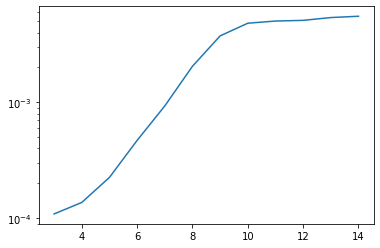

In [25]:
plt.semilogy(k_range, results_time/2000)